# Introduction to 🤗 Diffusers

In this notebook, you'll train your first diffusion model to **generate images of cute butterflies 🦋.** Along the way, you'll learn about the core components of the 🤗 Diffusers library, which will provide a good foundation for the more advanced applications that we'll cover later in the course.

Let's dive in!

## What You Will Learn

In this notebook you will:

- See a powerful custom diffusion model pipeline in action (with information on how to make your own version)
- Create your own mini pipeline by:
  - Recapping the core ideas behind diffusion models
  - Loading in data from the Hub for training
  - Exploring how we add noise to this data with a scheduler
  - Creating and training the UNet model
  - Putting the pieces together into a working pipeline
- Edit and run a script for initializing longer training runs, that will handle
  - Multi-GPU training via 🤗 Accelerate
  - Experiment logging to track critical stats
  - Uploading the final model to the Hugging Face Hub

❓If you have any questions, please post them on the `#diffusion-models-class` channel on the Hugging Face Discord server. If you haven't signed up yet, you can do so here: https://huggingface.co/join/discord

## Prerequisites

Before diving into the notebook, you should:

* 📖 Read the Unit 1 materials
* 🤗 Create an account on the Hugging Face Hub. If you haven't done so yet, you can do so here: https://huggingface.co/join

## Step 1: Setup

Run the following cell to install the diffusers library as well as a few other requirements:

Next, head over to https://huggingface.co/settings/tokens and create an access token with write permission if you don't already have one:

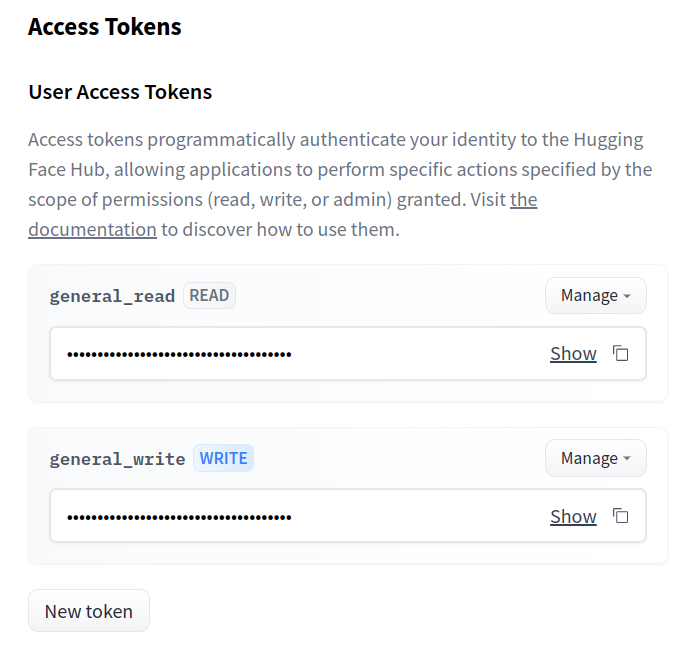

You can login with this token using the command line (`huggingface-cli login`) or by running the following cell:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/ricardo/.cache/huggingface/token
Login successful


Then you need to install Git-LFS to upload your model checkpoints:

Finally, let's import the libraries we'll be using and define a few convenience functions which we'll use later in the notebook:

In [11]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import torchvision
from torchsummary import summary


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

selected_gpu = 0 # here you select the GPU used (0, 1 or 2)
device = torch.device("cuda:" + str(selected_gpu) if torch.cuda.is_available() else "cpu")
print('The device is:', device)

The device is: cuda:0


OK, we're all set!

## Dreambooth: A Sneak Peak at What's to Come

If you've looked at AI-related social media at all in the past few months, you've heard about Stable Diffusion. It's a powerful text-conditioned latent diffusion model (don't worry, we'll learn what all that means). But it has a flaw: it doesn't know what you or I look like unless we're famous enough to have our images plastered around the internet. 

Dreambooth let's us create our own model variant with some extra knowledge of a specific face, object or style. The Corridor Crew made an excellent video using this to tell stories with consistent characters, which is a great example of what this technique can do:

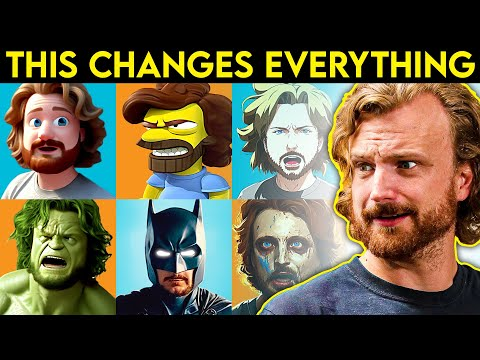

In [3]:
from IPython.display import YouTubeVideo

YouTubeVideo("W4Mcuh38wyM")

Here's an example using [a model](https://huggingface.co/sd-dreambooth-library/mr-potato-head) trained on 5 photos of a popular childrens toy called "Mr Potato Head".

First, we load the pipeline. This will download model weights etc. from the Hub. Since this will download several gigabytes of data for a one-line demo, you are welcome to skip this cell and simply admire the example output!

In [4]:
from diffusers import StableDiffusionPipeline

# Check out https://huggingface.co/sd-dreambooth-library for loads of models from the community
model_id = "sd-dreambooth-library/mr-potato-head"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(
    device
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/home/ricardo/miniconda3/envs/diffusion_class/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Once the pipeline has finished loading, we can generate images with:

  0%|          | 0/50 [00:00<?, ?it/s]

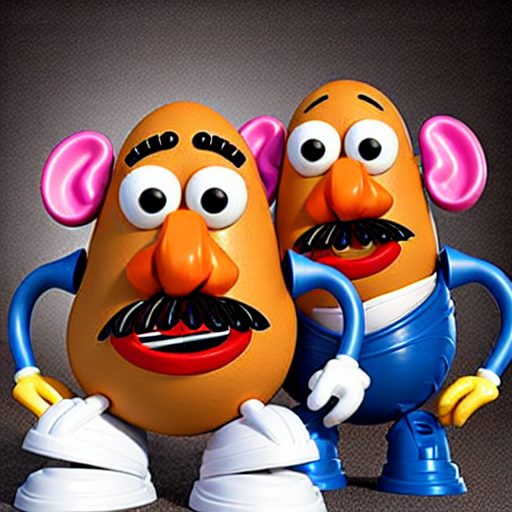

In [5]:
prompt = "photo of mr potato head getting married"
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image

**Exercise:** Try it yourself with different prompts. The `sks` token represents a unique identifier for the novel concept in this case - what happens if you leave that out? You can also experiment with changing the number of sampling steps (how low can you go?) and the `guidance_scale`, which determines how much the model will try to match the prompt.

There's a lot going on in that magical pipeline! By the end of the course you'll know how it all works. For now, let's take a look at how we can train a diffusion model from scratch.

## MVP (Minimum Viable Pipeline)

The core API of 🤗 Diffusers is divided into three main components:
1. **Pipelines**: high-level classes designed to rapidly generate samples from popular trained diffusion models in a <ins>user-friendly fashion</ins>.
2. **Models**: popular architectures for training new diffusion models, *e.g.* [UNet](https://arxiv.org/abs/1505.04597).
3. **Schedulers**: various techniques for generating images from noise during <ins>*inference*</ins> as well as to generate noisy images for <ins>*training*</ins>.

Pipelines are great for end-users, but if you're here for this course we assume you want to know what is going on under the hood! So, over the rest of this notebook we're going to build our own pipeline capable of generating small butterfly pictures. Here's the final result in action:

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

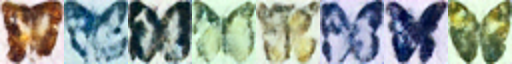

In [2]:
from diffusers import DDPMPipeline

# Load the butterfly pipeline
butterfly_pipeline = DDPMPipeline.from_pretrained(
    "johnowhitaker/ddpm-butterflies-32px"
).to(device)

# Create 8 images
images = butterfly_pipeline(batch_size=8).images

# View the result
make_grid(images)

Not as impressive as the DreamBooth example perhaps, but then we're training from scratch with ~0.0001% of the data used to train Stable Diffusion. Speaking of training, recall from the introduction to this unit that training a diffusion model looks something like this:


1.   Load in some images from the training data
2.   Add noise, in different amounts. 
3.   Feed the noisy versions of the inputs into the model
4.   Evaluate how well the model does at denoising these inputs
5.   Use this information to update the model weights, and repeat

We'll explore these steps one by one in the next few sections until we have a complete training loop working, and then we'll explore how to sample from the trained model and how to package everything up into a pipeline for easy sharing. Let's begin with the data...



## Step 2: Download a training dataset

For this example, we'll use a dataset of images from the Hugging Face Hub. Specifically, [this collection of 1000 butterfly pictures](https://huggingface.co/datasets/huggan/smithsonian_butterflies_subset). This is a very small dataset, so we've also included commented out lines for a few larger options. If you'd prefer to use your own collection of images, you can also use the commented-out code example to load in pictures from a folder instead.

In [78]:
import torchvision
from datasets import load_dataset
from torchvision import transforms

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")
# Or load images from a local folder
# dataset = load_dataset("imagefolder", data_dir="path/to/folder")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 64

# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    """Transform the images in the dataset to the desired format, this generates a dictionary with the key "images" containing the images in a list.

    Args:
        examples (dict): dictionary containing the images in a list under the key "image"

    Returns:
        dict: dictionary containing the images in a list under the key "images"
    """
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Using custom data configuration huggan--smithsonian_butterflies_subset-7665b1021a37404c
Found cached dataset parquet (/home/ricardo/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [79]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

We can grab a batch of images and view some of them like so:

In [72]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

KeyError: 'image'

We're sticking to a small dataset with 32 pixel images to keep training times manageable in this notebook.

## Step 3: Define the Scheduler

Our plan for training is to take these input images and add noise to them, then feed the noisy images to the model. And during inference, we will use the model predictions to iteratively remove noise. In `diffusers`,  these processes are *both* handled by the **scheduler**. 

The noise schedule determines how much noise is added at different timesteps. Here's how we might create a scheduler using the default settings for 'DDPM' training and sampling (based on the paper ["Denoising Diffusion Probabalistic Models"](https://arxiv.org/abs/2006.11239) *(Ho, 2020)*:

In [48]:
from diffusers import DDPMScheduler

#Linear defualt schedule
#noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# One with too little noise added:
#noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.004)
# The 'cosine' schedule, which may be better for small image sizes:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')


print('beta schedule:', noise_scheduler.beta_schedule)
print('beta start:', noise_scheduler.beta_start)
print('beta end:', noise_scheduler.beta_end)

beta schedule: squaredcos_cap_v2
beta start: 0.0001
beta end: 0.02


The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t accoridng to some schedule, and determines how much noise is added per timestep. Now, we don't necessariy want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

The maths notation always looks scary! Luckily the scheduler handles all that for us. We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps:

Text(0.5, 0, 'Timestep')

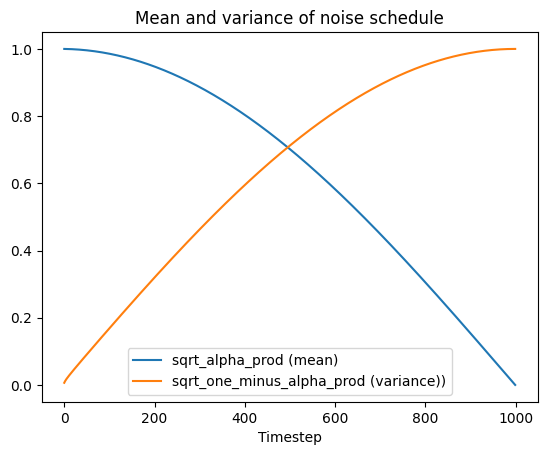

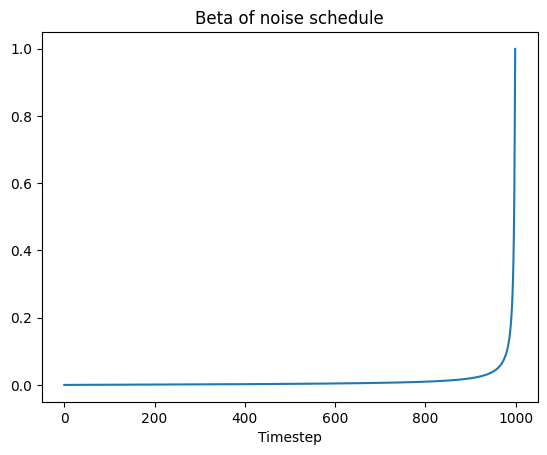

In [7]:
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label="sqrt_alpha_prod (mean)")
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label="sqrt_one_minus_alpha_prod (variance))"
)
plt.title("Mean and variance of noise schedule")
plt.xlabel("Timestep")
plt.legend();
#plot also the beta
plt.figure()
plt.title("Beta of noise schedule")
plt.plot(noise_scheduler.betas.cpu(), label="betas")
plt.xlabel("Timestep")

Whichever scheduler you've chosen, we can now use it to add noise in different amounts using the `noise_scheduler.add_noise` function like so:

Noisy X shape torch.Size([8, 3, 64, 64])


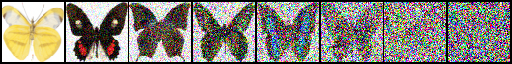

In [ ]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(original_samples=xb, noise=noise, timesteps=timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

Again, explore the effect of using different noise schedules and parameters here. [This video](https://www.youtube.com/watch?v=fbLgFrlTnGU) does a great job explaining some of the maths above in more detail, and is a great introduction to some of these concepts.

## Step 4: Define the Model

Now we come to the core component: the model itself. 

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:
- the model has the input image go through several blocks of ResNet layers, each of which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downample path to the corresponsding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size. 
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):

In [54]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device);

In [50]:
#check the model architecture
#print(model)

When dealing with higher-resolution inputs you may want to use more down and up-blocks, and keep the attention layers only at the lowest resolution (bottom) layers to reduce memory usage. We'll talk later about how you might experiment to find the best settings for your use-case.

We can check that passing in a batch of data and some random timesteps produces an output the same shape as the input data:

In [55]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 64, 64])

In the next section we'll see how to train this model.

## Step 5: Create a Training Loop

Time to train! Below is a typical optimization loop in PyTorch, where we run through the data batch by batch and update the parameters of our model each step using an optimizer - in this case the AdamW optimizer with a learning rate of 0.0004. 

For each batch of data, we
- Sample some random timesteps
- Noise the data accordingly
- Feed the noisy data through the model
- Compare the model predictions with the target (i.e. the noise in this case) using mean squared error as our loss function
- Update the model parameters via `loss.backward()` and `optimizer.step()`

During this process we also log the losses over time for later plotting.

NB: This code takes nearly 10 minutes to run - feel free to skip these two cells and use the pretrained model if you are in a hurry. Alternatively, you can explore how reducing the number of channels in each layer via the model definition above can speed things up.

The [official diffusers training example](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/training_example.ipynb) trains a larger model on this dataset at higher resolution, and is a good reference for what a less minimal training loop looks like:

In [65]:
#clean cache
torch.cuda.empty_cache()

epochs = 50

# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0] #batch size

        # Sample a random timestep for each image
        timesteps = torch.randint( #create bs random integers from init=0 to end=timesteps.
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long() #int64#mimages in batch to device

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        """Each image will have its own timestep randomly defined"""

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0] #first element is sample tensor

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss) #gradient of current tensor 
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

 10%|█         | 5/50 [01:01<09:11, 12.26s/it]

Epoch:5, loss: 0.0675489092245698


 20%|██        | 10/50 [02:02<08:11, 12.29s/it]

Epoch:10, loss: 0.056764539098367095


 30%|███       | 15/50 [03:04<07:10, 12.31s/it]

Epoch:15, loss: 0.05832337983883917


 40%|████      | 20/50 [04:05<06:09, 12.32s/it]

Epoch:20, loss: 0.05078466306440532


 50%|█████     | 25/50 [05:07<05:08, 12.33s/it]

Epoch:25, loss: 0.04472392192110419


 60%|██████    | 30/50 [06:09<04:06, 12.34s/it]

Epoch:30, loss: 0.04535886598750949


 70%|███████   | 35/50 [07:10<03:04, 12.33s/it]

Epoch:35, loss: 0.04921661666594446


 80%|████████  | 40/50 [08:12<02:03, 12.34s/it]

Epoch:40, loss: 0.04507846583146602


 90%|█████████ | 45/50 [09:14<01:01, 12.34s/it]

Epoch:45, loss: 0.04290144913829863


100%|██████████| 50/50 [10:16<00:00, 12.32s/it]

Epoch:50, loss: 0.043317975010722876


Plotting the loss, we see that the model rapidly improves initially and then continues to get better at a slower rate (which is more obvious if we use a log scale as shown on the right):

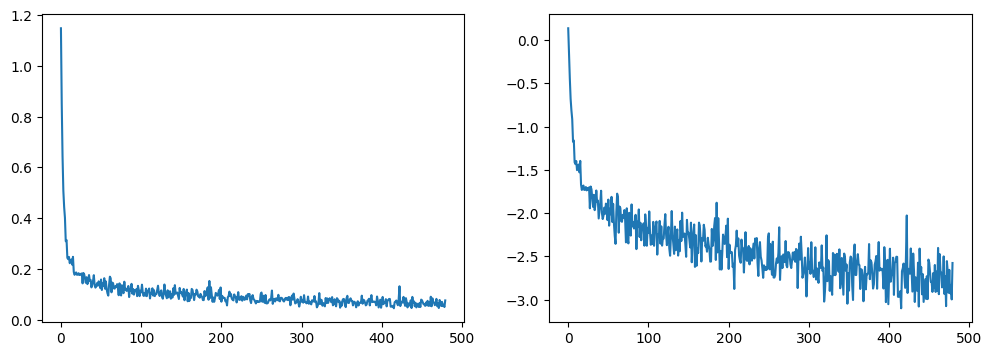

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

As an alternative to running the training code above, you can use the model from the pipeline like so:

In [ ]:
# Uncomment to instead load the model I trained earlier:
# model = butterfly_pipeline.unet

## Step 6: Generate Images

How do we get images with this model?

### Option 1: Creating a pipeline:

Create a pipeline with the model we just trained with:
- `model` is the model we just trained
- `noise_schedule` is the noise schedule we used to train the model

In [66]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

We can execute the pipeline and a batch of images (we decided the size) will be returned. <br>
<!-- Make the following text bigger because it is important -->
**Note**: The images are generated from pure noise using our model, so they will look like noise. <br>

  0%|          | 0/1000 [00:00<?, ?it/s]

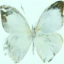

In [67]:
pipeline_output = image_pipe(batch_size=8)
pipeline_output.images[0]

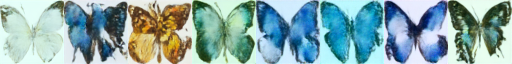

In [68]:
#here we show the full batch
make_grid(pipeline_output.images)

We can save a pipeline to a local folder like so:

In [61]:
image_pipe.save_pretrained("my_pipeline")

Inspecting the folder contents:

In [35]:
!ls my_pipeline/

model_index.json  scheduler  unet


The `scheduler` and `unet` subfolders contain everything needed to re-create those components. For example, inside the `unet` folder you'll find the model weights (`diffusion_pytorch_model.bin`) alongside a config file which specifies the unet architecture. 

In [36]:
!ls my_pipeline/unet/

config.json  diffusion_pytorch_model.bin


Together, these files contain everything needed to recreate the pipeline. You can manually upload them to the hub to share the pipeline with others, or check out the code to do this via the API in the next setcion.

### Option 2: Writing a Sampling Loop

If you inspect the forward method of the pipeline you'll be able to see what is happening when we run `image_pipe()`:

In [41]:
print(image_pipe)

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.12.1",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}



We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction:

100%|██████████| 1000/1000 [00:18<00:00, 52.77it/s]


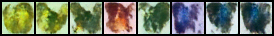

In [62]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

The `noise_scheduler.step()` function does the maths required to update `sample` appropriately. There are a number of sampling methods - in the next unit we'll see how we can swap in a different sampler to speed up image generation with existing models, and talk more about the theory behind sampling from diffusion models.

## Step 7: Push your model to the Hub

In the example above we saved our pipeline to a local folder. To push our model to the Hub, we will need to model repository to push our files to. We’ll determine the repository name from the model ID we want to give our model (feel free to replace the `model_name` with your own choice; it just needs to contain your username, which is what the function `get_full_repo_name()` does):

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "sd-class-butterflies-32"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'Likalto4/sd-class-butterflies-32'

Next, create a model repository on the 🤗 Hub and push our model:

In [ ]:
from huggingface_hub import HfApi, create_repo

create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path="my_pipeline/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(folder_path="my_pipeline/unet", path_in_repo="", repo_id=hub_model_id)
api.upload_file(
    path_or_fileobj="my_pipeline/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

'https://huggingface.co/Likalto4/sd-class-butterflies-32/blob/main/model_index.json'

The last thing to do is create a nice model card so that our butterfly generator can easily be found on the Hub (feel free to expand and edit the description!):

In [ ]:
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained({hub_model_id})
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

'https://huggingface.co/Likalto4/sd-class-butterflies-32/blob/main/README.md'

Now that the model is on the Hub, you can download it from anywhere by using the `from_pretrained()` method of the `DDPMPipeline` as follows"

Downloading:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/702 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/74.3M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/299 [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

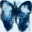

In [ ]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline.from_pretrained(hub_model_id)
pipeline_output = image_pipe()
pipeline_output.images[0]

Great it works!

# Scaling up with 🤗 Accelerate

This notebook was made for learning purposes, and as such I tried to keep the code as minimal and clean as possible. Because of this, we omitted some of the things you might want if you were to try training a larger model on much more data, such as multi-GPU support, logging of progress and example images, gradient checkpointing to support larger batch sizes, automatic uploading of models and so on. Thankfully most of these features are available in the example training script [here](https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py).

You can download the file like so:

In [ ]:
!wget https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py

--2022-11-29 18:09:56--  https://github.com/huggingface/diffusers/raw/main/examples/unconditional_image_generation/train_unconditional.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/huggingface/diffusers/main/examples/unconditional_image_generation/train_unconditional.py [following]
--2022-11-29 18:09:57--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/unconditional_image_generation/train_unconditional.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17338 (17K) [text/plain]
Saving to: ‘train_unconditional.py’

train_unconditional 100%[===================>]  16.

Open up the file and you'll see where the model is defined and what settings are available. I ran the script with the following command:

In [ ]:
# Let's give our new model a name for the Hub
model_name = "sd-class-butterflies-64"
hub_model_id = get_full_repo_name(model_name)
hub_model_id

'Likalto4/sd-class-butterflies-64'

In [ ]:
!accelerate launch train_unconditional.py \
  --dataset_name="huggan/smithsonian_butterflies_subset" \
  --resolution=64 \
  --output_dir={model_name} \
  --train_batch_size=32 \
  --num_epochs=50 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-4 \
  --lr_warmup_steps=500 \
  --mixed_precision="no"

	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Epoch 0: 100% 32/32 [00:29<00:00,  1.08it/s, ema_decay=0.924, loss=0.844, lr=6.4e-6, step=32]
/usr/local/lib/python3.7/dist-packages/diffusers/utils/deprecation_utils.py:35: FutureWarning: `todo: remove this check` is deprecated and will be removed in version 0.10.0. when the most used version is >= 0.8.0
  warnings.warn(warning + message, FutureWarning)
100% 1000/1000 [01:54<00:00,  8.71it/s]
Epoch 1: 100% 32/32 [00:28<00:00,  1.11it/s, ema_decay=0.955, loss=0.401, lr=1.28e-5, step=64]
Epoch 2: 100% 32/32 [00:28<00:00,  1.11it/s, ema_decay=0.967, loss=0.268, lr=1.92e-5, step=96]
Epoch 3: 100% 32/32 [00:29<00:00,  1.09it/s, ema_decay=0.974, loss=0.0828, lr=2.56e-5, step=128]
Epoch 4: 100% 32/32 [00:28<00:00,  1.11it/s, ema_decay=0.978, loss=0.052,

As before, let's push the model to the Hub and create a nice model card (and feel free to edit it as you wish!):

In [ ]:
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{model_name}/scheduler", path_in_repo="", repo_id=hub_model_id
)
api.upload_folder(
    folder_path=f"{model_name}/unet", path_in_repo="", repo_id=hub_model_id
)
api.upload_file(
    path_or_fileobj=f"{model_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---

# Model Card for Unit 1 of the [Diffusion Models Class 🧨](https://github.com/huggingface/diffusion-models-class)

This model is a diffusion model for unconditional image generation of cute 🦋.

## Usage

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained({hub_model_id})
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

About 45 minutes later, this is the result:

  0%|          | 0/1000 [00:00<?, ?it/s]

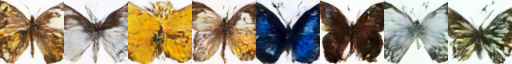

In [ ]:
pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=8).images
make_grid(images)

**Exercise:** See if you can find training/model settings that give good results in as little time as possible, and share your findings with the community. Dig around in the script to see if you can understand the code, and ask for clarification on anything that looks confusing.

# Avenues for Further Exploration

Hopefully this has given you a taste of what you can do with the 🤗 Diffusers library! Some possible next steps:

- Try training an unconditional diffusion model on a new dataset - bonus points if you [create one yourself](https://huggingface.co/docs/datasets/image_dataset). You can find some great image datasets for this task in the [HugGan organization](https://huggingface.co/huggan) on the Hub. Just make sure you downsample them if you don't want to wait a very long time for the model to train!
- Try out DreamBooth to create your own customized Stable Diffusion pipeline using either [this Space](https://huggingface.co/spaces/multimodalart/dreambooth-training) or [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_dreambooth_training.ipynb)
- Modify the training script to explore different unet hyperparameters (number of layers, channels etc), different noise schedules etc.
- Check out the [Diffusion Models from Scratch](https://github.com/huggingface/diffusion-models-class/blob/unit1/unit1/02_diffusion_models_from_scratch.ipynb) notebook for a different take on the core ideas we've covered in this unit

Good luck, and stay tuned for Unit 2!